<a href="https://colab.research.google.com/github/ProshkinNV/OpenCV/blob/main/GitHub_OpenCV_Arni.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Распознование лица на фотографии.
2. Выделение лица овалом.
3. Выделение на изображении глаз кругом.
Все лицо кроме глаз необходимо "заблюрить" (размыть) с помощью функции.

In [ ]:
import numpy as np
import cv2
import gdown
from matplotlib import pyplot

In [ ]:
gdown.download('https://storage.yandexcloud.net/preview/1661430367_29.jpg', None, quiet=True)
gdown.download('https://storage.yandexcloud.net/preview/123.png', None, quiet=True)

img = cv2.imread('./1661430367_29.jpg')

img2 = img.copy()

glasses = cv2.imread('./123.png')
h_mask, w_mask = glasses.shape[:2]

In [ ]:
#функция для блюра
def blur_face(img):
  (h, w) = img.shape[:2]
  dW = int(w / 3.0)
  dH = int(h / 3.0)
  if dW % 2 == 0:
      dW -= 1
  if dH % 2 == 0:
      dH -= 1
  return cv2.GaussianBlur(img, (dW, dH), 0)

In [ ]:
# Mask
maskShape = (img.shape[0], img.shape[1], 1)
mask = np.full(maskShape, 0, dtype=np.uint8)
mask_eye = np.full(maskShape,0, dtype=np.uint8)
mask_glasses = np.full(maskShape,0, dtype=np.uint8)

# загрузка каскадов
#глаза
classifier_eye = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_eye.xml")
#лицо
classifier_face = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

In [ ]:
#Выполнение распознования лица
face_box = classifier_face.detectMultiScale(img,scaleFactor = 3, minNeighbors=2, minSize=(50, 50))

for box in face_box:
  # формирование координат
  x, y, width, height = box
  x3,y3 = width-90,height-40

  #переносим центр овала на центр лица
  center = (int(x + 0.5*width), int(y + 0.5*height))

  # рисование овала
  cv2.ellipse(img2,center,(x3,y3),0,0,360,(255,0,0),1)
  cv2.ellipse(mask,center,(x3,y3),0,0,360,(255),-1)

  # создание области для блюра

  #создание переменных для увеличения области блюра
  y_blur_face,x_blur_face = y+height+100,x+width+100

  face = img2[int(y-100):y_blur_face, int(x-25):x_blur_face]

  face_glasees = img2[y:y + height, x:x + width]

In [ ]:
#Выполнение распознования глаз
eye_box = classifier_eye.detectMultiScale(img2)
for (x_eye,y_eye,w_eye,h_eye) in eye_box:

        # определяем центр круга
        center = (int(x_eye + 0.5*w_eye), int(y_eye + 0.5*h_eye))

        # вычисляем радиус окружности (подобран эмпирическим путем)
        radius = int(0.3 * (w_eye + h_eye))
        color = (0, 255, 0) # цвет в RGB (интенсивность цветов красный-зеленый-синий от 0 до 255)
        thickness = 3 # толщина линии
        # рисуем круг
        #cv2.circle(img2, center, radius, color, thickness)
        cv2.circle(mask_eye, center, radius, (255), -1)

In [ ]:
#активация функции блюра
img2 [int(y-100):y_blur_face, int(x-25):x_blur_face] = blur_face(face)

In [ ]:
#наложение слоев - лицо
mask_inv = cv2.bitwise_not(mask)
img1_bg = cv2.bitwise_and(img,img,mask = mask_inv)
img2_fg = cv2.bitwise_and(img2,img2,mask = mask)
dst = cv2.add(img1_bg,img2_fg)

In [ ]:
#наложение слоев - глаза
mask_inv2 = cv2.bitwise_not(mask_eye)
img11_bg = cv2.bitwise_and(dst,dst,mask = mask_inv2)
img22_fg = cv2.bitwise_and(img,img,mask = mask_eye)
dst2 =  cv2.add(img11_bg,img22_fg)

In [ ]:
#копия заблюренного изображения с глазами
img3 = dst2.copy()

In [ ]:
if len(eye_box) > 0:


  #область для наложения
  eye_all = img3[y:y + height, x:x + width]
  eye_all_h,eye_all_w,channels = eye_all.shape

  #маштабируем очки
  glasses_mask_small = cv2.resize(glasses,(eye_all_w,eye_all_h),interpolation=cv2.INTER_AREA)

  #бинарный порог
  gray_mask = cv2.cvtColor(glasses_mask_small, cv2.COLOR_BGR2GRAY)
  ret,mask_3 = cv2.threshold(gray_mask, 50, 255, cv2.THRESH_BINARY_INV)


  #наложение слоя очков
  mask_inv3 = cv2.bitwise_not(mask_3)
  img3_bg = cv2.bitwise_and(glasses_mask_small,glasses_mask_small, mask = mask_3)
  img3_fg = cv2.bitwise_and(eye_all,eye_all, mask = mask_inv3)
  dst3 =  cv2.add(img3_bg,img3_fg)

  img3[y:y + height, x:x + width] = dst3


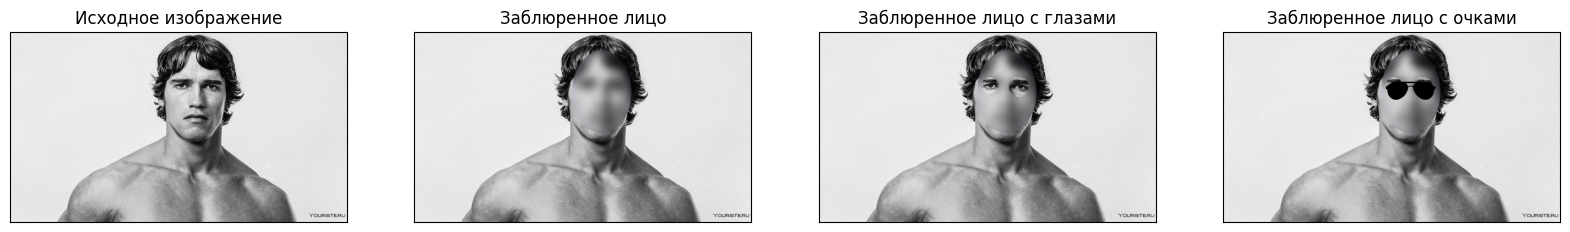

In [ ]:
fig, (ax1, ax2, ax3, ax4) = pyplot.subplots(1, 4, figsize=(20, 10))
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.xaxis.set_ticks([])
ax1.yaxis.set_ticks([])
ax1.set_title('Исходное изображение')

ax2.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))
ax2.xaxis.set_ticks([])
ax2.yaxis.set_ticks([])
ax2.set_title('Заблюренное лицо')

ax3.imshow(cv2.cvtColor(dst2, cv2.COLOR_BGR2RGB))
ax3.xaxis.set_ticks([])
ax3.yaxis.set_ticks([])
ax3.set_title('Заблюренное лицо с глазами')

ax4.imshow(cv2.cvtColor(img3, cv2.COLOR_BGR2RGB))
ax4.xaxis.set_ticks([])
ax4.yaxis.set_ticks([])
ax4.set_title('Заблюренное лицо с очками')
pyplot.show()